# Examples

## Conformal classification
We create a synthetic classification dataset with three classes.

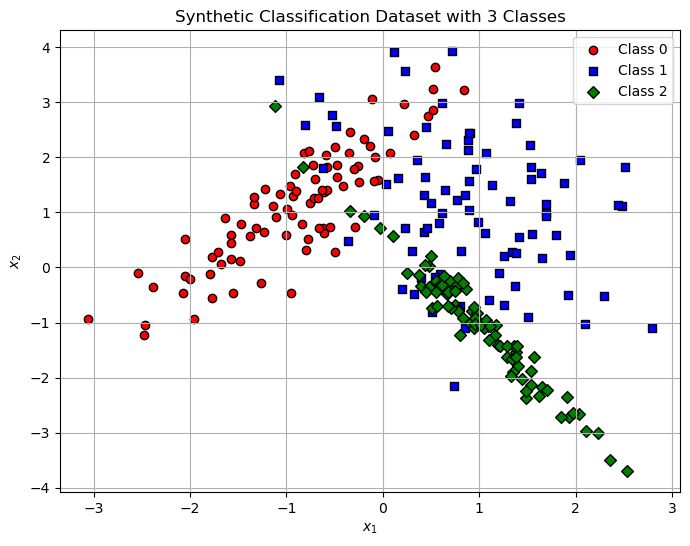

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

N = 250

X, y = make_classification(n_samples=N, n_features=2, n_informative=2, n_redundant=0, 
                           n_classes=3, n_clusters_per_class=1, random_state=2024)


# Create a scatter plot with different symbols for each class
plt.figure(figsize=(8, 6))

# Define different markers for each class
markers = ['o', 's', 'D']
colors = ['red', 'blue', 'green']

# Plot each class with a different marker
for label, marker, color in zip(np.unique(y), markers, colors):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}', marker=marker, color=color, edgecolor='k')

# Add labels and a legend
plt.title('Synthetic Classification Dataset with 3 Classes')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
from online_cp import ConformalNearestNeighboursClassifier

cp = ConformalNearestNeighboursClassifier(k=1)

To just test the conformal predictor on the dataset, we use the .process_dataset method. We can specify a significance level, an initial training set size, and we can return the prediction sets and the cummulative efficeincy criteria. The object returned is a dictionary.

In [3]:
result = cp.process_dataset(X=X, y=y, epsilon=0.1, init_train=0, return_results=True)

Under the key 'Efficiency' are the efficiency criteria and the average error, as well as the time it took to process the dataset.

In [4]:
result['Efficiency']

{'Average error': 0.112,
 'Average OE': 0.356,
 'Average OF': 0.14283112894006103,
 'Time': 1.7710566520690918}

The prediction sets are arrays with the included labels specified. An empty array indicate an empty prediciton set. These are returned only if specified with the return_results keyword.

In [5]:
result['Prediction sets']

({0: array([0, 1, 2]),
  1: array([0, 1, 2]),
  2: array([0, 1, 2]),
  3: array([0, 1, 2]),
  4: array([0, 1, 2]),
  5: array([0, 1, 2]),
  6: array([0, 1]),
  7: array([2]),
  8: array([2]),
  9: array([2]),
  10: array([0]),
  11: array([], dtype=float64),
  12: array([], dtype=float64),
  13: array([1]),
  14: array([2]),
  15: array([1]),
  16: array([1]),
  17: array([1, 2]),
  18: array([2]),
  19: array([0]),
  20: array([1, 2]),
  21: array([1, 2]),
  22: array([1]),
  23: array([2]),
  24: array([2]),
  25: array([0]),
  26: array([0]),
  27: array([0, 1]),
  28: array([0]),
  29: array([0, 1]),
  30: array([1]),
  31: array([0]),
  32: array([0]),
  33: array([0]),
  34: array([0]),
  35: array([0, 1]),
  36: array([0]),
  37: array([2]),
  38: array([0]),
  39: array([0, 1]),
  40: array([0, 1]),
  41: array([1, 2]),
  42: array([0, 1]),
  43: array([0]),
  44: array([1, 2]),
  45: array([0]),
  46: array([1]),
  47: array([0]),
  48: array([0, 1, 2]),
  49: array([2]),
  50

The remaining keys, which are only present if return_result is set to True, give the cummulative error  and efficiency criteria.

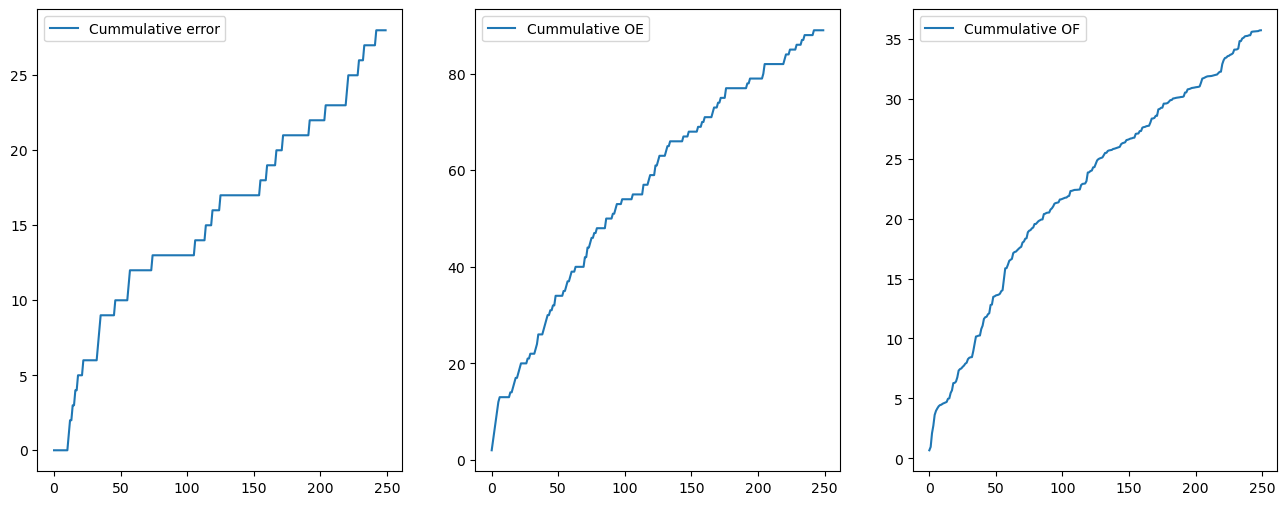

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16,6))
axs[0].plot(result['Cummulative Err'], label='Cummulative error')
axs[0].legend()

axs[1].plot(result['Cummulative OE'], label='Cummulative OE')
axs[1].legend()

axs[2].plot(result['Cummulative OF'], label='Cummulative OF')
axs[2].legend()

To reproduce the .process_dataset manually, we can do the following. Let's use the first 100 examples as initial training set. We can also use the p-values to test the exchangeability assumption with a test martingale.

In [7]:
res = np.zeros(shape=(y.shape[0], 3))
prediction_sets = {}

init_train = 100
X_train = X[:init_train]
y_train = y[:init_train]
X_run = X[init_train:]
y_run = y[init_train:]

cp = ConformalNearestNeighboursClassifier(k=1, label_space=np.unique(y))

from online_cp import PluginMartingale

martingale = PluginMartingale()


cp.learn_initial_training_set(X=X_train, y=y_train)

for i, (obj, lab) in enumerate(zip(X_run, y_run)):
    
    # Make prediction
    Gamma, p_values, D = cp.predict(obj, epsilon=0.1, return_p_values=True, return_update=True) 

    # Check error
    cp.err(Gamma, lab)

    # Learn the label
    cp.learn_one(obj, lab, D)

    # Update martingale
    martingale.update_martingale_value(p_values[lab])

    # Prefferred efficiency criteria

    # Observed excess
    cp.oe(Gamma, lab)

    # Observed fuzziness
    cp.of(p_values, lab)

    res[i, 0] = cp.OE
    res[i, 1] = cp.OF
    res[i, 2] = cp.Err
    prediction_sets[i] = Gamma

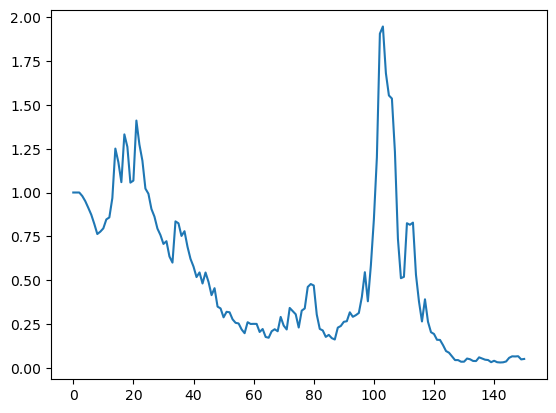

In [8]:
plt.plot(martingale.martingale_values)

## Conformal regression
We make a synthetic dataset 

In [9]:
rnd_gen = np.random.default_rng(2024)

N = 1000
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

If autotune is set to True, the ridge parameter is optimised using generalised cross validation.

In [10]:
from online_cp import ConformalRidgeRegressor

cp = ConformalRidgeRegressor(autotune=True)

result = cp.process_dataset(X=X, y=y, epsilon=0.1, init_train=int(N/2), return_results=True)

In [11]:
result['Efficiency']

{'Average error': 0.04,
 'Average width': np.float64(1.6788938357571561),
 'Time': 5.049106121063232}

Prediciton sets are now tuples with the first value indicating the lower bound of the interval, and the second value indicating the upper bound.

In [12]:
result['Prediction sets']

{0: (np.float64(-5.233660209711225), np.float64(-1.7901791517566994)),
 1: (np.float64(-7.304310718636233), np.float64(-3.782060582091079)),
 2: (np.float64(-5.515570208727553), np.float64(-2.0516227209745916)),
 3: (np.float64(-2.460605053555662), np.float64(0.9934013036451376)),
 4: (np.float64(2.7693766890091536), np.float64(6.255616683860714)),
 5: (np.float64(0.22073272319076584), np.float64(3.68662812088913)),
 6: (np.float64(-4.533851178098077), np.float64(-1.0916755944499437)),
 7: (np.float64(-4.043662517139392), np.float64(-0.5715577371570801)),
 8: (np.float64(-0.9190213160941734), np.float64(2.5429661035339906)),
 9: (np.float64(-2.030388763819264), np.float64(1.4153278817616757)),
 10: (np.float64(-0.8557780646157249), np.float64(2.5936777199631513)),
 11: (np.float64(-1.0546025944771238), np.float64(2.376205467948368)),
 12: (np.float64(-5.595465274274071), np.float64(-2.1482926029132305)),
 13: (np.float64(-2.849641730320389), np.float64(0.5982114211550177)),
 14: (np.fl

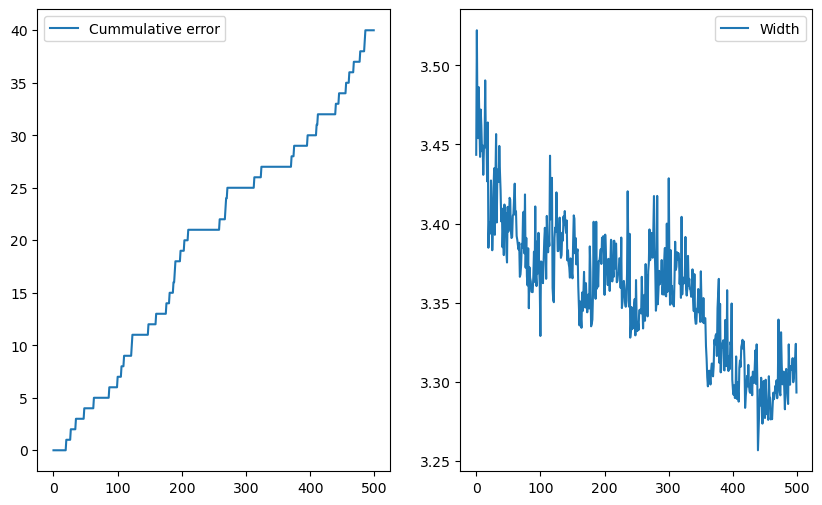

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,6))
axs[0].plot(result['Cummulative Err'], label='Cummulative error')
axs[0].legend()

axs[1].plot(result['Width'], label='Width')
axs[1].legend()

Again, we can do the same manually, but now, let us introcude a change point after the initial training set, and see if we can detect it with a conformal test martingale.

The computations for predicting a set, and learning the new label share many steps, so we can save some time by returning a precomputed object that can be passed to the learn_one and compute_smoothed_p_value methods.

In [15]:
beta1 = np.array([2, 1, 0, 0])
beta2 = np.array([0, 0, 1, 2])

Y1 = X[:int(N/2)] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
Y2 = X[int(N/2):N] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
y = np.concatenate([Y1, Y2])

init_train = int(N/2)

X_train = X[:init_train]
y_train = y[:init_train]
X_run = X[init_train:]
y_run = y[init_train:]

Err = 0
Width = 0

X_train = X[:init_train]
y_train = y[:init_train]
X_run = X[init_train:]
y_run = y[init_train:]

res = np.zeros(shape=(y_run.shape[0], 2))
prediction_sets = {}

cp = ConformalRidgeRegressor(autotune=True)

# Exchangeability assumption can be discarded with conficence 0.99 if the martingale calue exceeds 100
# If warnings are set to True, the martingale will issue a user warning once it grows beyind the warning level.
martingale = PluginMartingale(warning_level=100, warnings=False) 

cp.learn_initial_training_set(X=X_train, y=y_train)

for i, (obj, lab) in enumerate(zip(X_run, y_run)):
    
    # Make prediction
    Gamma, precomputed = cp.predict(obj, epsilon=0.1, return_update=True) 

    # Check error
    Err += cp.err(Gamma, lab)

    # Learn the label
    cp.learn_one(obj, lab, precomputed)

    # Compute smoothed p-value 
    p = cp.compute_p_value(x=obj, y=lab, precomputed=precomputed)
    
    # Update martingale
    martingale.update_martingale_value(p)
    
    # Width of interval
    width = cp.width(Gamma)
    Width += width

    res[i, 0] = Err
    res[i, 1] = width
    prediction_sets[i] = Gamma

Text(0.5, 1.0, 'Log martingale values')

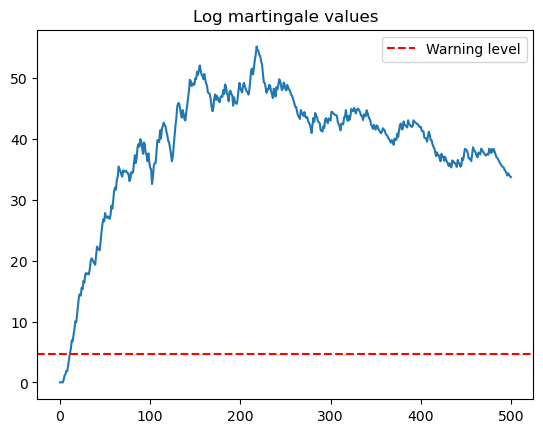

In [16]:
plt.plot(np.log(martingale.martingale_values))
plt.axhline(y=np.log(100), linestyle='--', color='red', label='Warning level')
plt.legend()
plt.title('Log martingale values')